# ChromHMM

Compare peak calling results with chromhmm

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False span=True sicer=True --rerun-trigger mtime;
```


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), '.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span = df_span[['_200_' not in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)
df_peaks.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/171 [00:00<?, ?it/s]

SPAN 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/96 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset
516,/home/jetbrains/data/2023_Immune/span/PBMC_H3K...,H3K27me3,PBMC,,59093,SPAN,Roadmap
45,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me1,H1,rep1,29669,MACS2,ENCODE
145,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K4me3,Huvec,rep1,24934,MACS2 broad,ENCODE


In [9]:
# Remove outliers
OUTLIERS = [('H3K4me3', 'NK', ''), ('H3K4me1', 'NK', ''), ('H3K27me3', 'TCell', ''), ('H3K27ac', 'CD34', ''), ('H3K27me3', 'NHLF', 'rep2'), ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

# ChromHMM

In [13]:
ENCODE_CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}


print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in ENCODE_CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

Split chromHMM into separate files
GM12878
H1
HepG2
K562


In [14]:
IMMUNE_CHROMHMM_MAP = {
    'BCell': IMMUNE_PATH + '/chromhmm/BCell_Chromhmm_hg38_ENCFF885QXH.bed',
    'TCell': IMMUNE_PATH + '/chromhmm/TCell_Chromhmm_hg38_ENCFF037LJR.bed',
    'Monocyte': IMMUNE_PATH + '/chromhmm/Monocyte_Chromhmm_hg38_ENCFF560DUU.bed',
    'NK': IMMUNE_PATH + '/chromhmm/NK_Chromhmm_hg38_ENCFF489XBL.bed',
    'CD4ABT': IMMUNE_PATH + '/chromhmm/CD4ABT_Chromhmm_hg38_ENCFF632AEU.bed',
    'CD34': IMMUNE_PATH + '/chromhmm/CD34_Chromhmm_hg38_ENCFF639FAH.bed',
    'PBMC': IMMUNE_PATH + '/chromhmm/PBMC_Chromhmm_hg38_ENCFF863IVL.bed'
}

print('Split chromHMM into separate files')
for c, chromhmm in IMMUNE_CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}

CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
BCell
TCell
Monocyte
NK
CD4ABT
CD34
PBMC
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [15]:
def compare_with_chromhmm(df_peaks, chromm_map):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    rows = []

    for (m, c, r), dft in tqdm(df_peaks.groupby(['modification', 'cell', 'replicate'])):
        print(m, c, r)
        if c not in chromm_map:
            continue
        chromhmm = chromm_map[c]
        for tool in TOOLS:
            t = dft[dft['tool'] == tool]
            if len(t) == 0: 
                continue
            peaks_file = sorted_file(t['file'].values[0])
            peaks = lines(peaks_file)
            row = [m, c, r, tool, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
                state_peaks = lines(tf)
                row.append(state_peaks)
            rows.append(row)

            if tool == 'SPAN':
                span_file = peaks_file

        # Processing single tools information
        for tool in TOOLS:
            if tool == 'SPAN':
                continue
            t = dft[dft['tool'] == tool]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
            ]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                row = [m, c, r, name, peaks]
                for state in CHROMM_STATES:
                    state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                    !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                    state_peaks = lines(tf2)
                    row.append(state_peaks)
                rows.append(row)

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)

In [16]:
encode_chromm = compare_with_chromhmm(df_encode_peaks, ENCODE_CHROMHMM_MAP)
encode_chromm['dataset'] = 'ENCODE'
encode_chromm.sample(3)

  0%|          | 0/85 [00:00<?, ?it/s]

H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac H1 rep1
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27me3 GM12878 rep1
H3K27me3 GM12878 rep2
H3K27me3 H1 rep1
H3K27me3 H1 rep2
H3K27me3 HMEC rep1
H3K27me3 HMEC rep2
H3K27me3 HSMM rep1
H3K27me3 HSMM rep2
H3K27me3 HepG2 rep1
H3K27me3 HepG2 rep2
H3K27me3 Huvec rep1
H3K27me3 Huvec rep2
H3K27me3 K562 rep1
H3K27me3 K562 rep2
H3K27me3 NHEK rep1
H3K27me3 NHEK rep2
H3K27me3 NHLF rep1
H3K27me3 NHLF rep2
H3K36me3 GM12878 rep1
H3K36me3 GM12878 rep2
H3K36me3 H1 rep1
H3K36me3 H1 rep2
H3K36me3 HMEC rep1
H3K36me3 HMEC rep2
H3K36me3 HSMM rep1
H3K36me3 HSMM rep2
H3K36me3 HepG2 rep1
H3K36me3 HepG2 rep2
H3K36me3 Huvec rep1
H3K36me3 Huvec rep2
H3K36me3 K562 rep1
H3K36me3 K562 rep2
H3K36me3 NHEK rep2
H3K36me3 NHLF rep1
H3K36me3 NHLF rep2
H3K4me1 G

,modification,cell,replicate,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
301,H3K4me3,GM12878,rep1,MACS2 broad,29024,10678,5145,638,1179,1035,...,1662,1185,11101,946,17721,8854,7507,4829,4720,0
345,H3K4me3,HepG2,rep2,MACS2 - SPAN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,H3K4me1,H1,rep2,MACS2,18,8,0,1,0,2,...,0,0,0,1,9,0,9,0,0,0


In [17]:
immune_chromm = compare_with_chromhmm(df_immune_peaks, IMMUNE_CHROMHMM_MAP)
immune_chromm['dataset'] = 'Roadmap'
immune_chromm.sample(3)

  0%|          | 0/46 [00:00<?, ?it/s]

H3K27ac BCell 
H3K27ac CD34 
H3K27ac CD34 rep2
H3K27ac CD4 
H3K27ac CD4 rep1
H3K27ac Monocyte 
H3K27ac NK 
H3K27ac PBMC 
H3K27ac TCell 
H3K27me3 BCell 
H3K27me3 CD34 
H3K27me3 CD34 rep2
H3K27me3 CD4 
H3K27me3 CD4 rep2
H3K27me3 Monocyte 
H3K27me3 NK 
H3K27me3 PBMC 
H3K27me3 TCell 
H3K36me3 BCell 
H3K36me3 CD34 
H3K36me3 CD34 rep1
H3K36me3 CD4 
H3K36me3 CD4 rep1
H3K36me3 Monocyte 
H3K36me3 PBMC 
H3K36me3 TCell 
H3K4me1 BCell 
H3K4me1 CD34 
H3K4me1 CD34 rep2
H3K4me1 CD4 
H3K4me1 CD4 rep1
H3K4me1 Monocyte 
H3K4me1 NK 
H3K4me1 TCell 
H3K4me3 BCell 
H3K4me3 CD34 
H3K4me3 CD34 rep2
H3K4me3 CD4 
H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 Monocyte 
H3K4me3 NK 
H3K4me3 PBMC 
H3K4me3 TCell 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2


,modification,cell,replicate,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
56,H3K27ac,PBMC,,SPAN - MACS2 broad,5498,88,149,55,268,0,...,69,66,22,71,572,528,7,2044,1781,0
169,H3K36me3,CD34,rep1,SICER - SPAN,855,47,18,1,16,6,...,4,4,4,1,41,20,28,388,384,0
17,H3K27ac,CD34,,MACS2 broad - SPAN,11468,478,86,59,302,70,...,156,112,61,201,653,231,451,6334,3141,0


In [20]:
encode_chromm['dataset'] = 'ENCODE'
immune_chromm['dataset'] = 'Roadmap'
chromhmm_df = pd.concat([encode_chromm, immune_chromm]).reset_index(drop=True)
chromhmm_df.sample(3)

,modification,cell,replicate,name,peaks,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,...,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts,dataset
319,H3K4me3,GM12878,rep2,SICER - SPAN,2934,951,473,78,316,75,...,214,12,17,287,199,35,1370,1281,0,ENCODE
637,H3K4me3,BCell,,MACS2 broad - SPAN,823,215,17,244,12,30,...,18,3,121,181,127,42,13,12,0,Roadmap
106,H3K27me3,H1,rep2,SPAN - MACS2 broad,6513,68,5,2200,9,3,...,3241,111,2112,1446,614,93,305,298,0,ENCODE


In [24]:
chromhmm_df[['dataset', 'modification', 'name'] + CHROMM_STATES].groupby(
    ['dataset', 'modification', 'name']).mean().reset_index()

,dataset,modification,name,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,ENCODE,H3K27ac,MACS2,14635.142857,5034.571429,151.857143,1052.142857,1694.714286,6668.571429,91.428571,...,133.285714,85.714286,15207.714286,542.857143,15445.714286,2004.428571,10742.000000,2364.571429,2154.285714,0.0
1,ENCODE,H3K27ac,MACS2 - SPAN,174.142857,28.714286,9.857143,78.571429,15.000000,361.428571,8.285714,...,25.428571,16.714286,76.857143,34.142857,256.571429,76.285714,109.285714,202.571429,149.857143,0.0
2,ENCODE,H3K27ac,MACS2 broad,10893.714286,4613.285714,211.285714,1896.714286,1452.142857,9900.571429,169.571429,...,327.142857,228.857143,10044.571429,481.714286,11936.285714,3378.285714,8346.714286,4733.857143,4128.285714,0.0
3,ENCODE,H3K27ac,MACS2 broad - SPAN,474.285714,92.285714,46.571429,298.714286,46.000000,1307.857143,40.000000,...,168.571429,114.714286,140.571429,94.000000,512.142857,202.428571,223.142857,1075.000000,770.857143,0.0
4,ENCODE,H3K27ac,SICER,12213.142857,5829.142857,463.000000,4066.142857,1662.428571,18703.142857,584.000000,...,1010.857143,837.714286,10325.285714,742.142857,13859.285714,7136.571429,8883.285714,15651.428571,14348.714286,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Roadmap,H3K4me3,SICER - SPAN,239.555556,40.333333,51.666667,47.333333,25.000000,330.111111,14.000000,...,93.111111,64.111111,10.000000,28.111111,156.111111,61.444444,99.222222,264.777778,218.333333,0.0
96,Roadmap,H3K4me3,SPAN,7285.444444,1703.555556,2475.888889,1297.666667,1002.000000,10663.333333,57.555556,...,1470.333333,912.444444,10299.222222,3750.333333,18710.000000,8270.666667,15105.555556,3834.222222,3350.555556,0.0
97,Roadmap,H3K4me3,SPAN - MACS2,751.888889,81.000000,167.555556,124.777778,60.000000,831.333333,26.333333,...,180.333333,128.444444,54.222222,133.222222,707.222222,286.666667,398.333333,553.888889,430.111111,0.0
98,Roadmap,H3K4me3,SPAN - MACS2 broad,475.333333,42.666667,92.000000,62.555556,37.555556,463.111111,19.000000,...,101.111111,72.222222,29.777778,47.000000,368.444444,158.666667,194.888889,301.666667,229.222222,0.0


In [26]:
chromhmm_df_mean = chromhmm_df[['dataset', 'modification', 'name'] + CHROMM_STATES].groupby(
    ['dataset', 'modification', 'name']).mean().reset_index()
chromhmm_df_mean.sample(3)

,dataset,modification,name,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,ENCODE,H3K27ac,MACS2,14635.142857,5034.571429,151.857143,1052.142857,1694.714286,6668.571429,91.428571,...,133.285714,85.714286,15207.714286,542.857143,15445.714286,2004.428571,10742.000000,2364.571429,2154.285714,0.0
1,ENCODE,H3K27ac,MACS2 - SPAN,174.142857,28.714286,9.857143,78.571429,15.000000,361.428571,8.285714,...,25.428571,16.714286,76.857143,34.142857,256.571429,76.285714,109.285714,202.571429,149.857143,0.0
2,ENCODE,H3K27ac,MACS2 broad,10893.714286,4613.285714,211.285714,1896.714286,1452.142857,9900.571429,169.571429,...,327.142857,228.857143,10044.571429,481.714286,11936.285714,3378.285714,8346.714286,4733.857143,4128.285714,0.0
3,ENCODE,H3K27ac,MACS2 broad - SPAN,474.285714,92.285714,46.571429,298.714286,46.000000,1307.857143,40.000000,...,168.571429,114.714286,140.571429,94.000000,512.142857,202.428571,223.142857,1075.000000,770.857143,0.0
4,ENCODE,H3K27ac,SICER,12213.142857,5829.142857,463.000000,4066.142857,1662.428571,18703.142857,584.000000,...,1010.857143,837.714286,10325.285714,742.142857,13859.285714,7136.571429,8883.285714,15651.428571,14348.714286,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Roadmap,H3K4me3,SICER - SPAN,239.555556,40.333333,51.666667,47.333333,25.000000,330.111111,14.000000,...,93.111111,64.111111,10.000000,28.111111,156.111111,61.444444,99.222222,264.777778,218.333333,0.0
96,Roadmap,H3K4me3,SPAN,7285.444444,1703.555556,2475.888889,1297.666667,1002.000000,10663.333333,57.555556,...,1470.333333,912.444444,10299.222222,3750.333333,18710.000000,8270.666667,15105.555556,3834.222222,3350.555556,0.0
97,Roadmap,H3K4me3,SPAN - MACS2,751.888889,81.000000,167.555556,124.777778,60.000000,831.333333,26.333333,...,180.333333,128.444444,54.222222,133.222222,707.222222,286.666667,398.333333,553.888889,430.111111,0.0
98,Roadmap,H3K4me3,SPAN - MACS2 broad,475.333333,42.666667,92.000000,62.555556,37.555556,463.111111,19.000000,...,101.111111,72.222222,29.777778,47.000000,368.444444,158.666667,194.888889,301.666667,229.222222,0.0


ENCODE H3K27ac


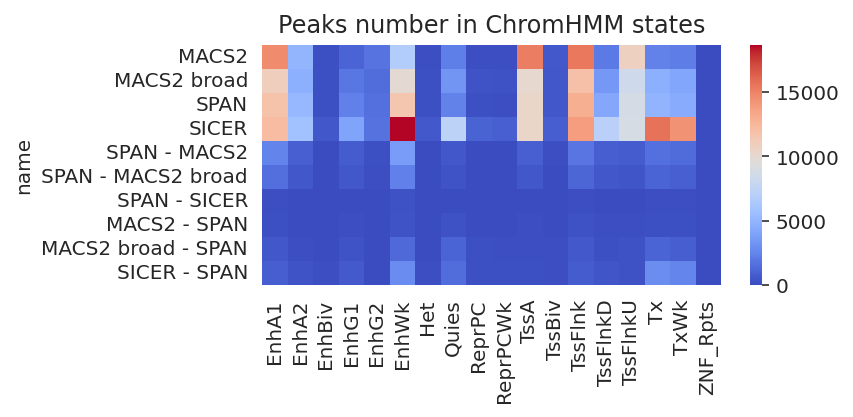

ENCODE H3K27me3


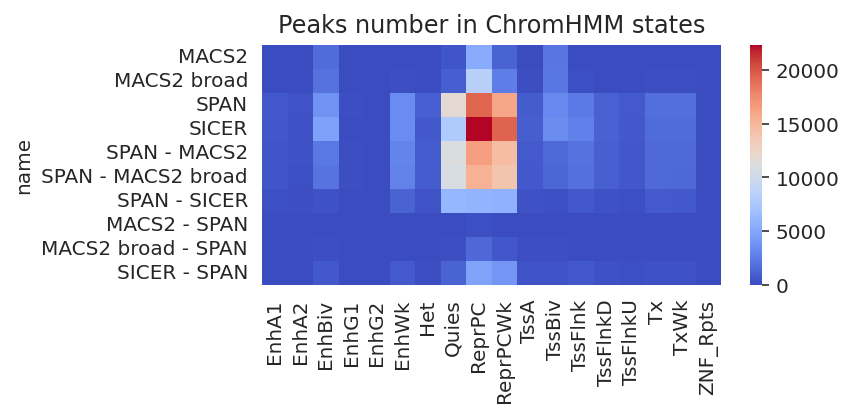

ENCODE H3K36me3


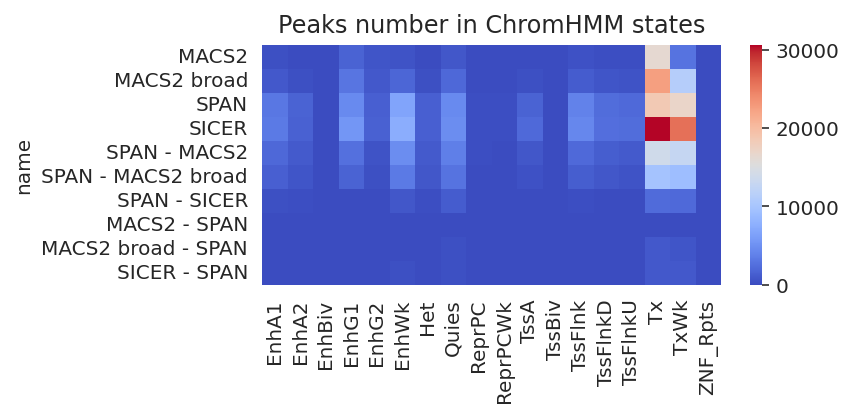

ENCODE H3K4me1


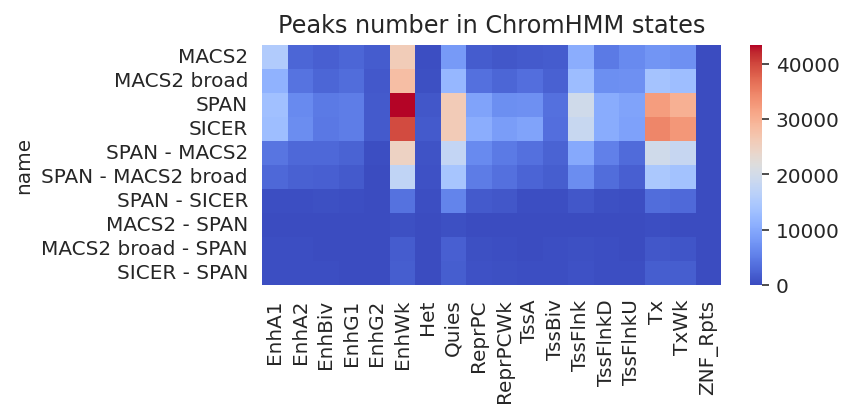

ENCODE H3K4me3


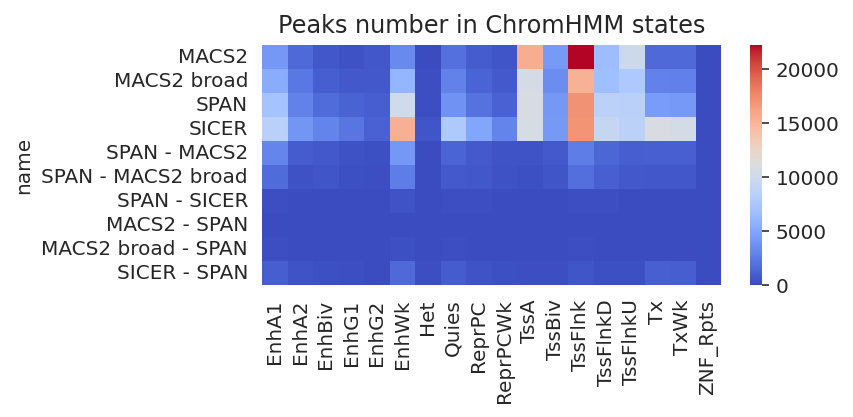

Roadmap H3K27ac


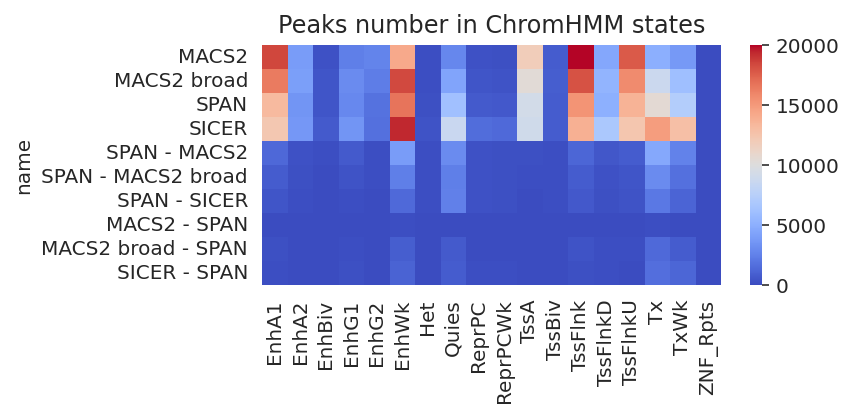

Roadmap H3K27me3


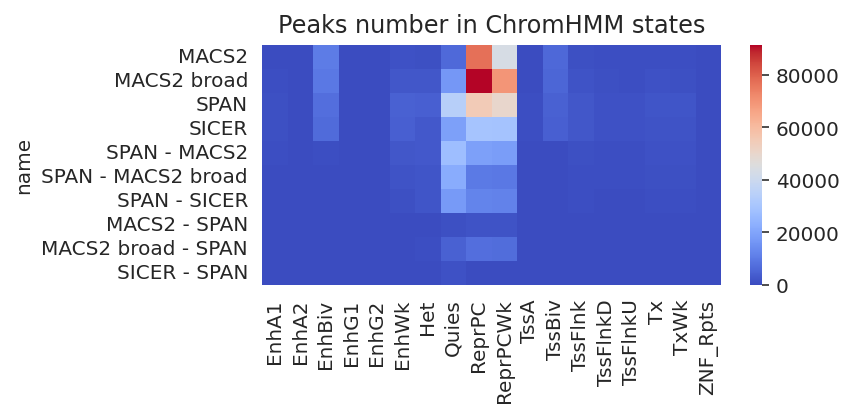

Roadmap H3K36me3


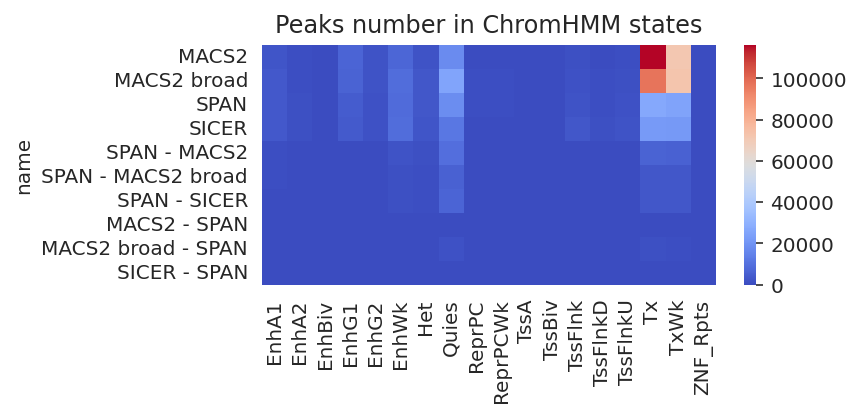

Roadmap H3K4me1


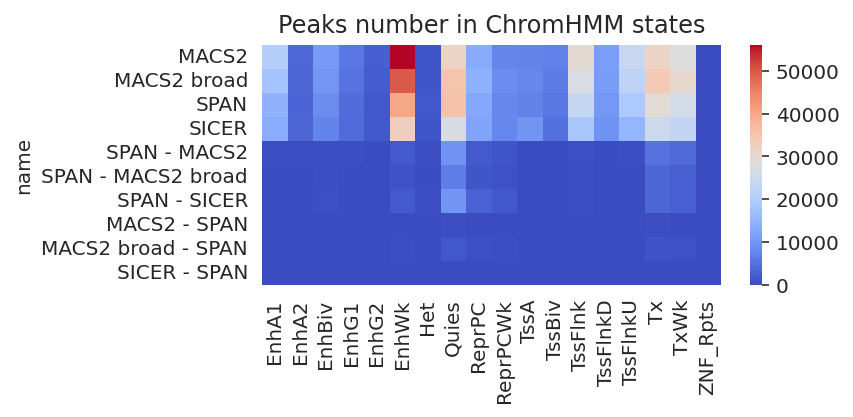

Roadmap H3K4me3


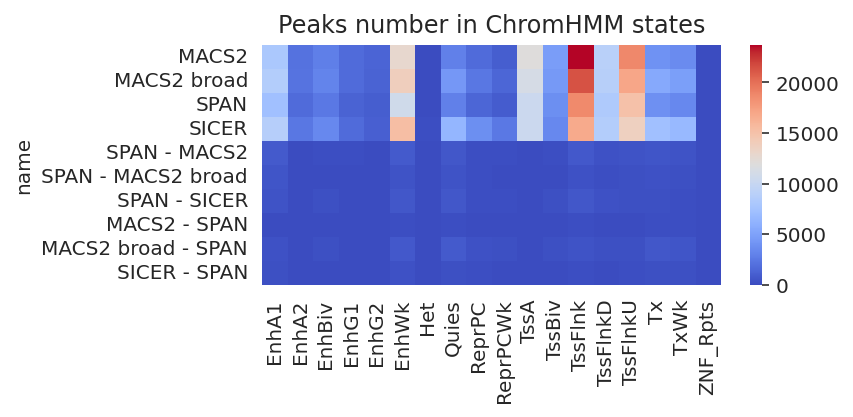

In [30]:
for (ds, m), dft in chromhmm_df_mean.groupby(['dataset', 'modification']):
    print(ds, m)
    plt.figure(figsize=(6, 3))
    t = dft[['name'] + CHROMM_STATES]
    t.set_index('name', inplace=True)
    sns.heatmap(t.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ]], cmap='coolwarm')
    plt.title('Peaks number in ChromHMM states')
    plt.tight_layout()
    plt.show()

In [37]:
chromhmm_rel_df = chromhmm_df[['dataset', 'modification', 'name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['dataset', 'modification', 'name'] + CHROMM_STATES].groupby(
    ['dataset', 'modification', 'name']).mean().reset_index()

,dataset,modification,name,EnhA1,EnhA2,EnhBiv,EnhG1,EnhG2,EnhWk,Het,...,ReprPC,ReprPCWk,TssA,TssBiv,TssFlnk,TssFlnkD,TssFlnkU,Tx,TxWk,ZNF_Rpts
0,ENCODE,H3K27ac,MACS2,0.361161,0.123255,0.003312,0.023013,0.040765,0.145620,0.001992,...,0.002864,0.001830,0.418156,0.012083,0.383334,0.044728,0.269004,0.052070,0.047658,0.0
1,ENCODE,H3K27ac,MACS2 - SPAN,0.206333,0.021826,0.003320,0.060907,0.007080,0.263312,0.007671,...,0.012278,0.009536,0.029133,0.012561,0.113307,0.039803,0.040719,0.258961,0.238432,0.0
2,ENCODE,H3K27ac,MACS2 broad,0.403383,0.170646,0.006515,0.061978,0.053038,0.324912,0.005398,...,0.009497,0.006684,0.400732,0.015806,0.449285,0.112965,0.314798,0.151832,0.133594,0.0
3,ENCODE,H3K27ac,MACS2 broad - SPAN,0.083226,0.042134,0.004421,0.062026,0.006492,0.349223,0.008787,...,0.016907,0.012156,0.030662,0.010818,0.134581,0.054389,0.030207,0.258784,0.207613,0.0
4,ENCODE,H3K27ac,SICER,0.413076,0.191837,0.016488,0.138196,0.057304,0.631020,0.019054,...,0.034752,0.028531,0.350487,0.026007,0.470366,0.242658,0.308137,0.523638,0.479316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Roadmap,H3K4me3,SICER - SPAN,0.546027,0.064244,0.082513,0.063053,0.068520,0.507493,0.009251,...,0.093581,0.056808,0.009465,0.036250,0.203465,0.087774,0.123456,0.189875,0.166281,0.0
96,Roadmap,H3K4me3,SPAN,0.238314,0.045942,0.081603,0.018516,0.026952,0.288742,0.001646,...,0.033573,0.020168,0.387531,0.136935,0.684312,0.323379,0.544174,0.055211,0.049041,0.0
97,Roadmap,H3K4me3,SPAN - MACS2,0.312111,0.018985,0.062427,0.018885,0.023701,0.224596,0.005825,...,0.037886,0.025480,0.008658,0.036962,0.242468,0.117544,0.118076,0.073802,0.058724,0.0
98,Roadmap,H3K4me3,SPAN - MACS2 broad,0.299132,0.017033,0.052385,0.018128,0.023066,0.215030,0.007078,...,0.037227,0.025804,0.007320,0.022008,0.201524,0.106653,0.087100,0.076771,0.059675,0.0


ENCODE H3K27ac


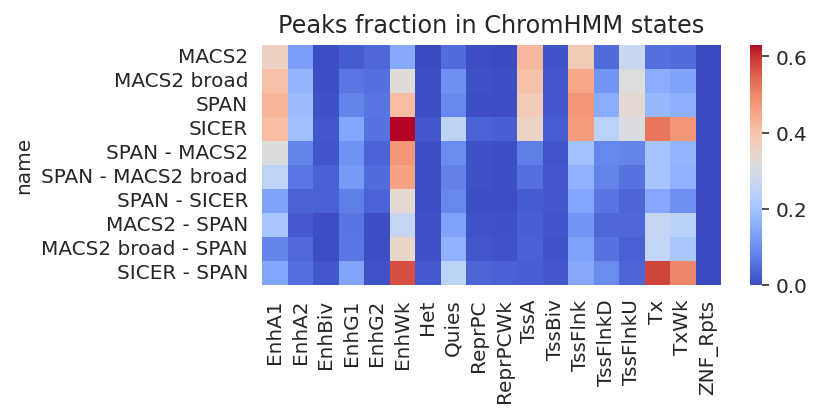

ENCODE H3K27me3


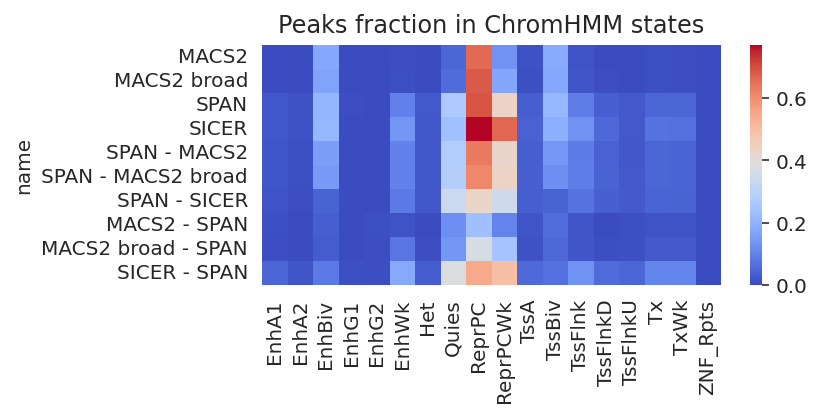

ENCODE H3K36me3


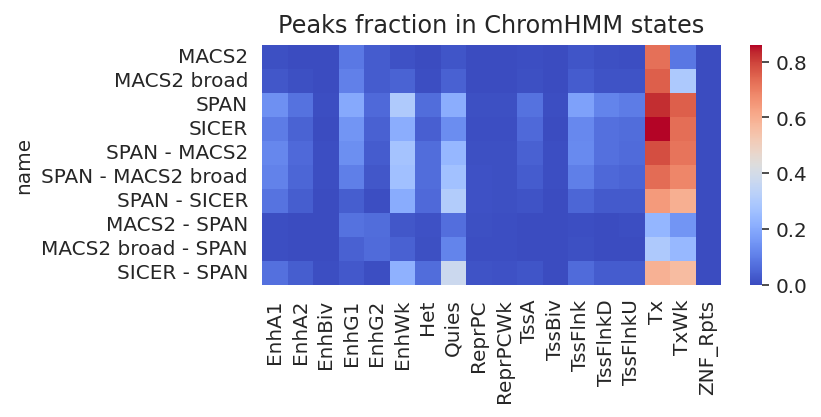

ENCODE H3K4me1


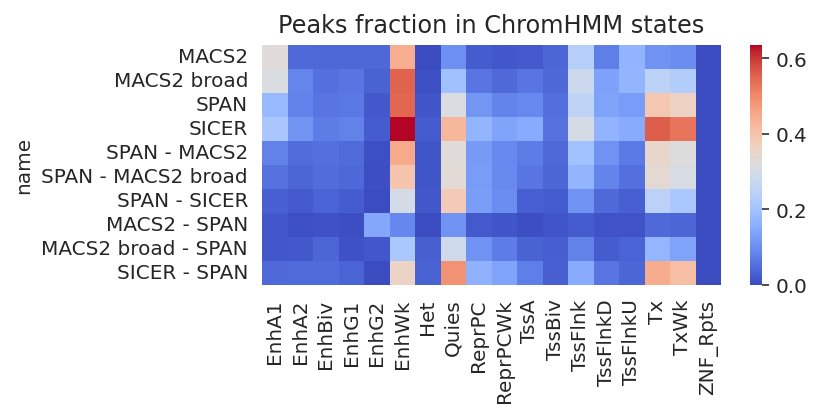

ENCODE H3K4me3


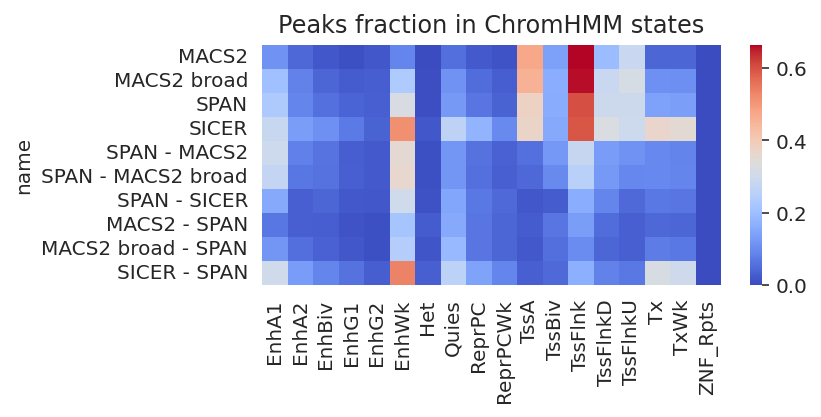

Roadmap H3K27ac


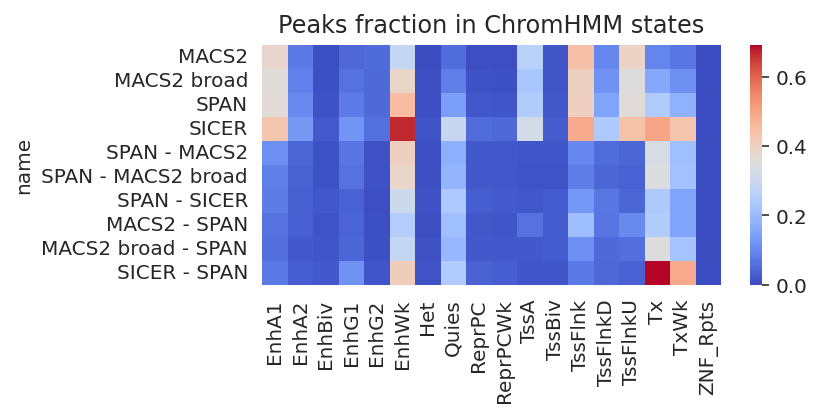

Roadmap H3K27me3


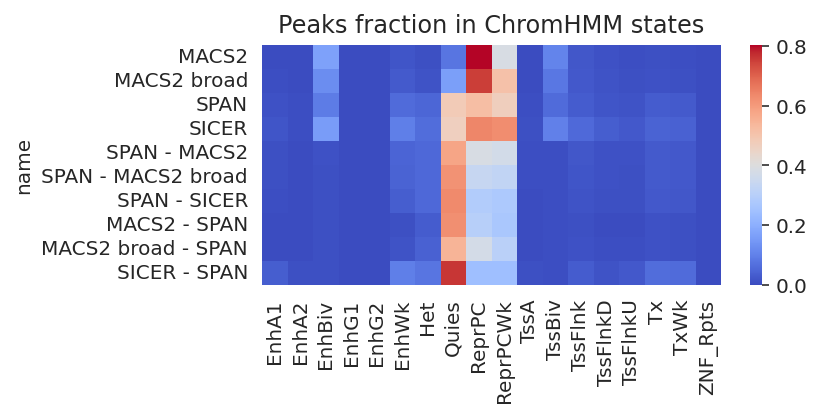

Roadmap H3K36me3


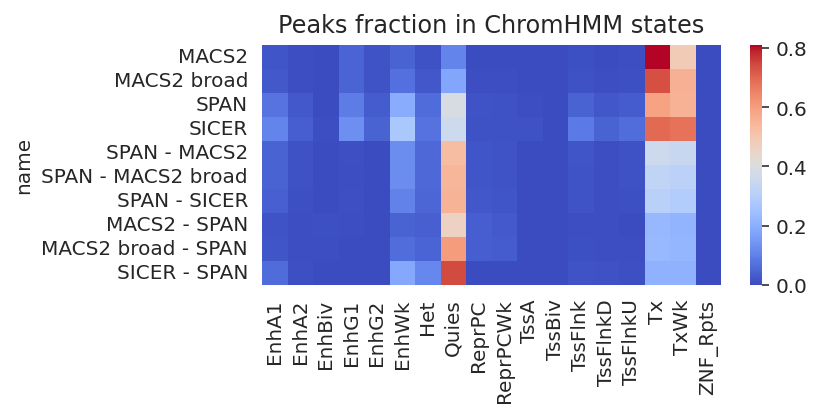

Roadmap H3K4me1


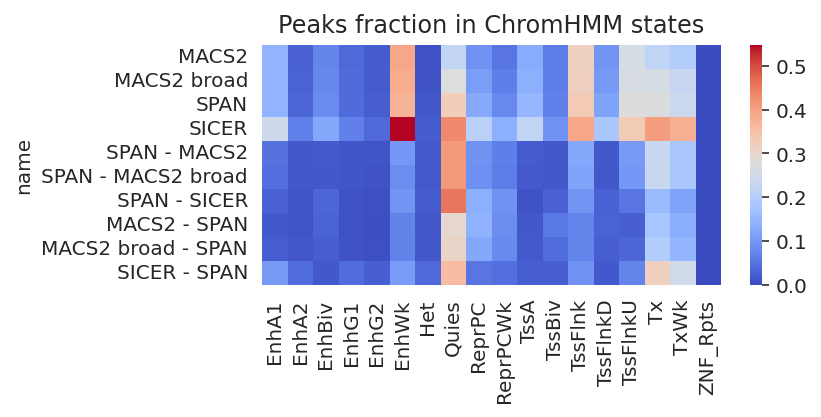

Roadmap H3K4me3


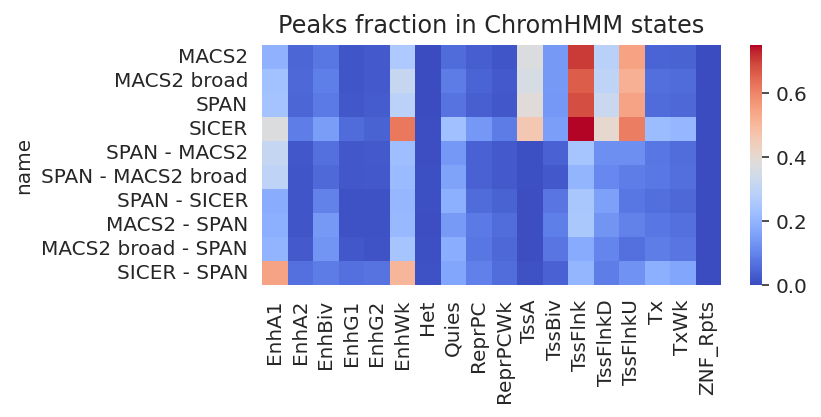

In [38]:
for (ds, m), dft in chromhmm_rel_df_mean.groupby(['dataset', 'modification']):
    print(ds, m)
    plt.figure(figsize=(6, 3))
    t = dft[['name'] + CHROMM_STATES]
    t.set_index('name', inplace=True)
    sns.heatmap(t.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ]], cmap='coolwarm')
    plt.title('Peaks fraction in ChromHMM states')
    plt.tight_layout()
    plt.show()